In [ ]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations



%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.std(x) # the function to calculate z-score
p_score = lambda x: 100 * np.sum(x <= x[i]) / len(x)

normalize_to_max = lambda x:(x/np.nanmax(x))


main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)

current_sessions = [x for x in range(17) if x not in (12, 13)] # RatV sessions for now and Roy familiar sessions were excluded

number_of_sessions = len(current_sessions)

epoch_names = ['pre_nrem', 'pre_qw', 'pre_rem', 'maze_theta', 'maze', 'post_nrem', 'post_qw', 'post_rem'] # combination of behavioral epoch and sleep/wake state
epoch_names2 = ['SWS\nripples', 'Quiet wake\nripples', 'REM', 'Theta', 'Quiet wake\nripples', 'SWS\nripples', 'Quiet wake\nripples', 'REM']

num_units = np.empty((number_of_sessions,), dtype=int)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE

learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

gw = gausswindow(3, 9) # for smoothing the tunings 
flag = 1

for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))


    session_dataset_path = os.path.join(main_dir, session_name)


    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]



    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size

    
    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}
        # unit_spikes['peak_firing_rate'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        # unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
        # unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
        # unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        spikes.append(unit_spikes) 


    # # load MAZE PF stability
    # maze_place_field_stabilities_curr_session = loadmat(os.path.join(session_dataset_path, session_name + '.PFstability.mat'))['PF_stability_across_blocks']


    """
    Learned tunings during different epochs
    """
    
    # Load .mat file
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_Lthresh1e_3.mat'))
    
    # active units
    # active_units = mat_file["activeUnits"]["post"].item().reshape([-1])
    # active_units = active_units - 1 # to account for python zero indexing
    # num_units[session_idx] = len(active_units)

    # loading the learned tunings from differnet .mat sources
    learned_tunings_curr_session = dict()
    
    learned_tunings_curr_session['maze'] = mat_file["assemblyTunings"]['run'].item()['data'].item()


    # learned tunings based on separate QW and NREM ripples 
    filename = f'{session_name}.learned_tunings_NREM_vs_QW.npy'
    file_path = os.path.join(session_dataset_path, filename)
    learned_tunings_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

    learned_tunings_curr_session['pre_nrem'] = learned_tunings_NREM_vs_QW['PRE']['learned_tunings_NREM']
    learned_tunings_curr_session['pre_qw'] = learned_tunings_NREM_vs_QW['PRE']['learned_tunings_QW']

    learned_tunings_curr_session['post_nrem'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_NREM']
    learned_tunings_curr_session['post_qw'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_QW']


    # MAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_activeRun_binDur0.02.mat'))
    learned_tunings_curr_session['maze_theta'] = mat_file['learnedTunings']


    # REM learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, 'NREM_REM_', session_name + '.assemblyTunings_REM.mat'))
    
    learned_tunings_curr_session['pre_rem'] = mat_file['assemblyTunings']['pre'].item()[0][0][0]
    learned_tunings_curr_session['post_rem'] = mat_file['assemblyTunings']['post'].item()[0][0][0]


    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit

        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

    active_units = np.where(np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1)[0]
    # active_units = np.where(peak_place_field_fr > 1)[0]
    num_units[session_idx] = len(active_units)
    
    spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])


    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16

    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()
    num_shuffles = 10000
    for epoch, epoch_name in enumerate(epoch_names):

        learned_tunings[session_idx][epoch_name] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[epoch_name][active_units[unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            # An additional smoothing of the learned tunings during the sleep epochs
            if epoch in range(1,5): # PRE, MAZE, POST, or latePOST
                curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            # learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            learned_tunings[session_idx][epoch_name][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][epoch_name],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )

    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)



### Pooling the data across sessions and sort the units based on their peak place fields in the interpolated spatial tunings
##### In this section, we will combine the spatial tuning curves for each session and sort the neurons based on their peak spatial tuning values. This will help us visualize the overall spatial tuning properties of the neurons across all sessions.

In [82]:

# concatenate place fields from all sessions and sort them according to the peak place field locations

spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

spatial_tunings_maze_sessions_concat = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]

# place_field_stability_maze_concat = np.concatenate(place_field_stability_maze, axis=0)
# place_field_stability_maze_concat = place_field_stability_maze_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_session_number_sessions_concat = each_unit_session_number_sessions_concat[place_fields_sort_idx]


# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_place_field_population_vector_correlation = dict.fromkeys(epoch_names)
for epoch, epoch_name in enumerate(epoch_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][epoch_name])
    learned_tunings_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)
    learned_tunings_sessions_concat[epoch_name] = learned_tunings_sessions_concat[epoch_name][place_fields_sort_idx]

    # population vector correlation between the learned tunings and the place fields
    learned_tunings_place_field_population_vector_correlation[epoch_name] = calculate_all_column_correlations(learned_tunings_sessions_concat[epoch_name], spatial_tunings_maze_sessions_concat)

# population vector correlation between the NREM and QW learned tunings for PRE and POST

learned_tunings_nrem_qw_population_vector_correlation_pre = calculate_all_column_correlations(learned_tunings_sessions_concat['pre_nrem'], learned_tunings_sessions_concat['pre_qw'])
learned_tunings_nrem_qw_population_vector_correlation_post = calculate_all_column_correlations(learned_tunings_sessions_concat['post_nrem'], learned_tunings_sessions_concat['post_qw'])


learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
learned_tunings_place_field_corr_p_values_concat = dict.fromkeys(epoch_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(epoch_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(epoch_names)

for epoch, epoch_name in enumerate(epoch_names):
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][epoch_name])
    learned_tunings_place_field_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_sessions_concat[epoch_name] = learned_tunings_place_field_corr_sessions_concat[epoch_name][place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name][place_fields_sort_idx]

    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[epoch_name] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[epoch_name])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[epoch_name] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[epoch_name])/num_shuffles




### Plotting Learned Tunings and Population Vector Correlation Matrices
##### In this section, we plot the learned tunings and the population vector correlation matrices between the learned tunings and the place fields. The correlation matrices provide an estimate of how well the learned tunings align with the place fields. The cumulative distribution of the place fidelity of the learned tunings is also plotted.


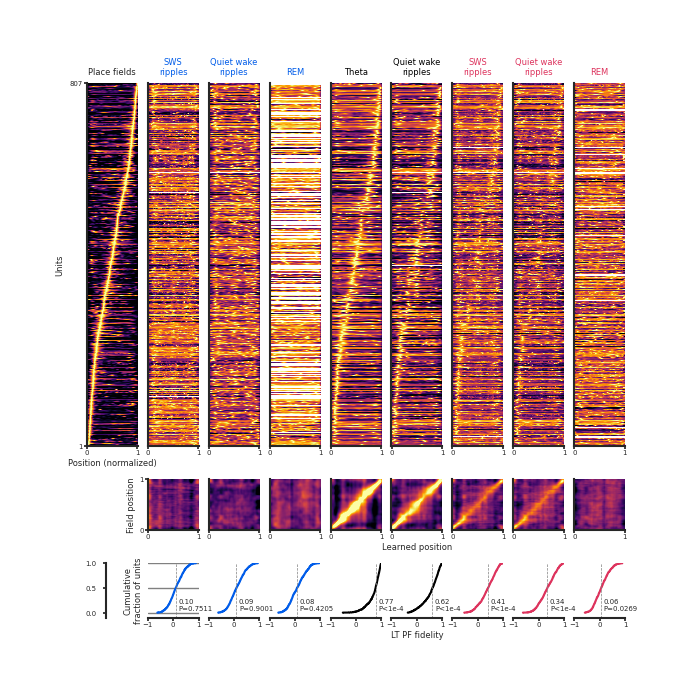

In [129]:
# Create figure and subplots
plotheight = 500
plotwidth = 500
font_size = 6

epoch_names2 = ['SWS\nripples', 'Quiet wake\nripples', 'REM', 'Theta', 'Quiet wake\nripples', 'SWS\nripples', 'Quiet wake\nripples', 'REM']
colors = [
    '#005CE9', # PRE
    'black',# MAZE
    '#DD335D' # # POST
    ] 
def get_epoch_color(i):
    if i<= 2:
        color = colors[0]    
    elif i <=4:
        color = colors[1]
    else:
        color = colors[2]
    return color
        

sns.set_style('whitegrid')
sns.set_context('paper')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.sans-serif'] = 'Arial'

# plt.rcParams['font.size'] = font_size

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=len(epoch_names)+1, figure=fig, height_ratios=[1, 0.15, 0.15])

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement
c_map = 'inferno'


# plot MAZE place fields
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(spatial_tunings_maze_sessions_concat, vmin=0, vmax=1, cmap=c_map, aspect='auto', interpolation='none', origin='lower')
ax0.set_xticks([0, 199])
ax0.set_xticklabels(['0', '1'])
ax0.set_yticks([0, learned_tunings_sessions_concat[epoch].shape[0] - 1])
ax0.set_yticklabels(['1', str(learned_tunings_sessions_concat[epoch].shape[0])])
ax0.set_ylabel('Units', fontsize = font_size)

ax0.set_xlabel('Position (normalized)', fontsize = font_size, labelpad=2)
ax0.set_title('Place fields', fontsize = font_size)
ax0.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)


# plot epoch's learned tunigs
for i, epoch in enumerate(epoch_names):
    ax1 = fig.add_subplot(gs[0, i+1])
    ax1.imshow(learned_tunings_sessions_concat[epoch], vmin=0, vmax=1, cmap=c_map, aspect='auto', interpolation='none', origin='lower')
    ax1.set_xticks([0, 199])
    ax1.set_xticklabels(['0', '1'])
    ax1.set_yticks([])
    ax1.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)
    ax1.set_title(epoch_names2[i], color= get_epoch_color(i), fontsize = font_size)


# plot population vector correlations between position bins in learned tunings and place fields
for i, epoch in enumerate(epoch_names):
    ax2 = fig.add_subplot(gs[1, i+1])
    ax2.imshow(learned_tunings_place_field_population_vector_correlation[epoch], vmin=0, vmax=0.5, cmap=c_map, aspect='auto', interpolation='none', origin='lower')
    ax2.set_xticks([0, 199])
    ax2.set_xticklabels(['0', '1'])

    if i == 0:
        ax2.set_yticks([0, 199])
        ax2.set_yticklabels(['0', '1'])
    else:
        ax2.set_yticks([])
    
    if i==0:
        ax2.set_ylabel('Field position', fontsize = font_size, labelpad=2)

    if i==4:    
        ax2.set_xlabel('Learned position', fontsize = font_size, labelpad=2)

    ax2.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)
    ax2.set_aspect('equal')

    # ax2.set_title(epoch_names2[i])


# plot the cumulative distributions of PF fidelities (of learned tunings)
for i, epoch in enumerate(epoch_names):
    ax3 = fig.add_subplot(gs[2,i+1])
    ax3.set_facecolor((0, 0, 0, 0))  # Set the background to transparent

    sns.ecdfplot(learned_tunings_place_field_corr_sessions_concat[epoch], ax = ax3, label={epoch}, color=get_epoch_color(i), linewidth = 1.5)
    ax3.set_xlim([-1,1])
    
    if i > 0:
        ax3.set_yticks([])

    if i==4:
        ax3.set_xlabel('LT PF fidelity', fontsize=font_size, labelpad=2)
    if i==0:
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['left'].set_position(('outward', 30))
        ax3.set_ylabel('Cumulative\nfraction of units', fontsize = font_size, labelpad=2)

    else:
        ax3.set_ylabel('')
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['left'].set_visible(False)

    ax3.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)

    
    ax3.yaxis.set_label_coords(-0.1, 0.5)  # Move the y-axis label to the left a bit
    ax3.spines['left'].set_bounds(-0.1, 1.0)  # Set the bounds of the y-axis spine
    
    # Move the y-axis labels and ticks up a bit
    for tick in ax3.yaxis.get_major_ticks():
        tick.set_pad(5)
    
    ax3.set_ylim(bottom=-0.1)

    # adding medians and their p-values
    ax3.axvline(lt_pf_correlation_median_across_all_sessions[epoch], color='gray', linestyle='dashed', linewidth=0.5)
    xpos = lt_pf_correlation_median_across_all_sessions[epoch]+0.1
    ypos = 0.05
    ax3.text(xpos, ypos, "{:.2f}\n{}".format(lt_pf_correlation_median_across_all_sessions[epoch], get_pval_statement(lt_pf_correlation_median_across_all_sessions_pvalue[epoch])), fontsize=5)
    ax3.grid(axis='y', color='gray', linewidth=1)



plt.show()

filename = 'Figure2_NREM_QW_separate.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


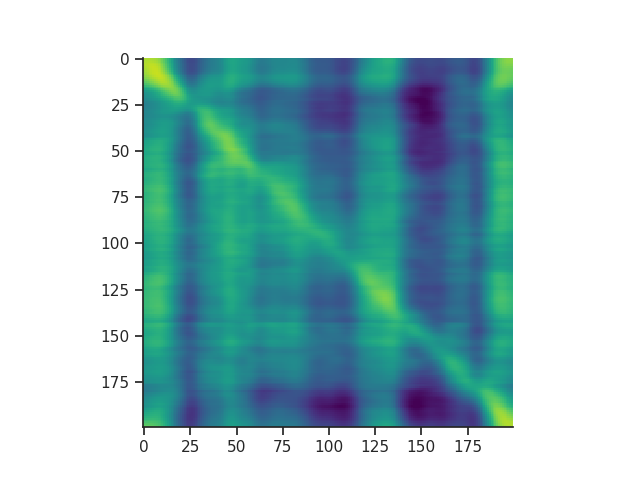

In [45]:
fig = plt.figure()
plt.imshow(learned_tunings_nrem_qw_population_vector_correlation_pre, vmin=0, vmax=0.7, interpolation='none', cmap='viridis')